# Project 2.1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. import data and data cleaning

In [ ]:
data = pd.read_excel('sample ab_data.xlsx')

In [3]:
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104.0,11:48.6,control,old_page,0.0
1,804228.0,01:45.2,control,old_page,0.0
2,661590.0,55:06.2,treatment,new_page,1.0
3,853541.0,28:03.1,treatment,new_page,1.0
4,864975.0,52:26.2,control,old_page,1.0


In [4]:
data.info()

# no missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   user_id       294478 non-null  float64
 1   timestamp     294478 non-null  object 
 2   group         294478 non-null  object 
 3   landing_page  294478 non-null  object 
 4   converted     294478 non-null  float64
dtypes: float64(2), object(3)
memory usage: 11.2+ MB


In [9]:
#1. check多少 old_page /new_page
data[['group','landing_page']].value_counts()

#发现异常，there are 1965 ppl from treatment group were assigned to old_page, 
# and 1928 from control were assigned to new_page.
# I chose to delete since there are enough database

group      landing_page
treatment  new_page        145311
control    old_page        145274
treatment  old_page          1965
control    new_page          1928
dtype: int64

In [13]:
correct_assign = ((data['group'] == 'treatment') & (data['landing_page'] == 'new_page'))|((data['group'] == 'control') & (data['landing_page'] == 'old_page'))
data_clean = data[correct_assign]
data_clean[['group','landing_page']].value_counts()

# clean and balance

group      landing_page
treatment  new_page        145311
control    old_page        145274
dtype: int64

In [26]:

data_clean['user_id'].value_counts().sort_values(ascending = False)

773192.0    2
834487.0    1
936923.0    1
679687.0    1
719014.0    1
           ..
677163.0    1
643562.0    1
857744.0    1
923948.0    1
715931.0    1
Name: user_id, Length: 290584, dtype: int64

In [27]:
#有重复的 user_id， 看一下是什么情况
# 第一次coverted, 第二次 didnt covert
data_clean[data['user_id']==773192.0]

/var/folders/85/jcyy_w7d4g5cdzprsfn0tngh0000gn/T/ipykernel_62195/3609572330.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_clean[data['user_id']==773192.0]


,user_id,timestamp,group,landing_page,converted
1899,773192.0,37:58.8,treatment,new_page,1.0
2893,773192.0,55:59.6,treatment,new_page,0.0


In [55]:
# make assumption？
convert = (data['user_id']==773192.0) & (data['converted']==1)
f_convert = (data['user_id']==773192.0) & (data['converted']==0)

data1 = data_clean[-f_convert]
data2 = data_clean[-convert]

/var/folders/85/jcyy_w7d4g5cdzprsfn0tngh0000gn/T/ipykernel_62195/176654154.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1 = data_clean[-f_convert]
/var/folders/85/jcyy_w7d4g5cdzprsfn0tngh0000gn/T/ipykernel_62195/176654154.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2 = data_clean[-convert]


In [56]:
# if count as convert
data1 = data1.groupby('group').agg(count = ('converted', 'count'), mean = ('converted', 'mean')).reset_index()
data1.columns = [['group', 'user_num', 'conversion_rate']]
data1

,group,user_num,conversion_rate
0,control,145274,0.120386
1,treatment,145310,0.125360


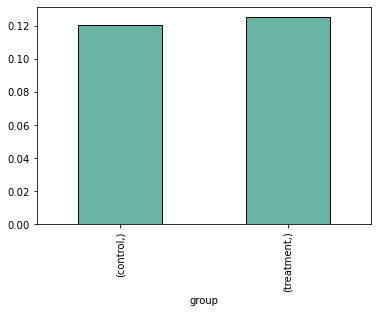

In [75]:
plot_data = data1.set_index('group')[['conversion_rate']]

ax = plot_data.plot(
    kind='bar',
    color=['#69b3a2'],  
    legend=False,
    figsize=(6, 4),
    edgecolor='black'
)

In [58]:
# if count as fail to convert
data2 = data2 = data2.groupby('group').agg(
    count=('converted', 'count'),
    mean=('converted', 'mean')
).reset_index()
data2.columns = [['group', 'user_num', 'conversion_rate']]
data2

,group,user_num,conversion_rate
0,control,145274,0.120386
1,treatment,145310,0.125353


In [59]:
#差别并不大， 所以用第一种来做分析

# 2.Analyze results

lets assume the new page does not have higher conversion rate than the old page at 5% Type I error. So the hypothesis woule be:

alpha = 0.05

null hypothesis: there is no significant difference b/w treatment and control group, p_new <= p_old

alternative hypothesis: there is significant difference b/w treatment and control group, p_new > p_old

its gonna be a one-tail test

In [84]:
data1 = data_clean[-f_convert]
data1[['group','converted']].value_counts()

/var/folders/85/jcyy_w7d4g5cdzprsfn0tngh0000gn/T/ipykernel_62195/2711167756.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1 = data_clean[-f_convert]


group      converted
control    0.0          127785
treatment  0.0          127094
           1.0           18216
control    1.0           17489
dtype: int64

In [86]:
con_0 = data1[['group','converted']].value_counts()[0]
tre_0 = data1[['group','converted']].value_counts()[1]
tre_1 = data1[['group','converted']].value_counts()[2]
con_1 = data1[['group','converted']].value_counts()[3]
con_n = con_0+con_1
tre_n = tre_0+tre_1

In [89]:
# 由于N的数量很大，因此应该用 Z-test
import statsmodels.api as sm

z_state, p_value = sm.stats.proportions_ztest([tre_1, con_1],[tre_n, con_n], alternative='larger') #one tail, treatment>control


In [100]:
z_state, p_value

# p远远< 0.05
# 这说明there is significate diff b/w treatment and control
# there for new_page is better, it does help to increase conversion rate

(4.083082708291715, 2.2217176514639505e-05)

In [94]:
#尝试一下t-test
tre = data1[data1['group']=='treatment']['converted']
con = data1[data1['group']=='control']['converted']
t_state, p_value,dfree = sm.stats.ttest_ind(tre,con, alternative='larger')

In [95]:
p_value

# p远远< 0.05
# 这说明there is significate diff b/w treatment and control
# there for new_page is better, it does help to increase conversion rate

2.2217176514639505e-05

手动计算z-test

Z = (p1-p2)/sqrt(p*(1-p)(1/n1+1/n2))

p1 treatment 转化率

p2 control 转化率

p_pool	合并转化率（pooled proportion）：

In [96]:
p1 = tre_1/tre_n
p2 = con_1/con_n
p = (tre_1+con_1)/(tre_n + con_n)


In [102]:
from scipy.stats import norm
Z = (p1-p2)/np.sqrt(p*(1-p)*(1/tre_n+1/con_n))
p_value = 1 - norm.cdf(Z) #one tail
Z, p_value

#结果一样

(4.083082708291715, 2.2221098369135106e-05)

# 3. EDA

In [155]:
data1.head()

,user_id,timestamp,group,landing_page,converted,minutes
0,851104.0,11:48.6,control,old_page,0.0,11
1,804228.0,01:45.2,control,old_page,0.0,1
2,661590.0,55:06.2,treatment,new_page,1.0,55
3,853541.0,28:03.1,treatment,new_page,1.0,28
4,864975.0,52:26.2,control,old_page,1.0,52


In [117]:
#转换时间
data1['time'] = pd.to_timedelta('00:' + data1['timestamp'])
data1['minutes'] = data1['time'].dt.components['minutes']
del data1['time']

/var/folders/85/jcyy_w7d4g5cdzprsfn0tngh0000gn/T/ipykernel_62195/2460010955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['time'] = pd.to_timedelta('00:' + data1['timestamp'])
/var/folders/85/jcyy_w7d4g5cdzprsfn0tngh0000gn/T/ipykernel_62195/2460010955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['minutes'] = data1['time'].dt.components['minutes']


In [158]:
data1.head()

,user_id,timestamp,group,landing_page,converted,minutes
0,851104.0,11:48.6,control,old_page,0.0,11
1,804228.0,01:45.2,control,old_page,0.0,1
2,661590.0,55:06.2,treatment,new_page,1.0,55
3,853541.0,28:03.1,treatment,new_page,1.0,28
4,864975.0,52:26.2,control,old_page,1.0,52


In [196]:
df1 = data1[['minutes','group','user_id']].groupby(['minutes','group']).count().reset_index()
df1['user_id'] = df1.groupby('group')['user_id'].cumsum()
df1.head()

,minutes,group,user_id
0,0,control,2456
1,0,treatment,2371
2,1,control,4739
3,1,treatment,4775
4,2,control,7111


In [191]:
data11 = data1[data1['converted']==1]
df2 = data11[['minutes','group','user_id']].groupby(['minutes','group']).count().reset_index()
df2['user_id'] = df2.groupby('group')['user_id'].cumsum()
df2.head()

,minutes,group,user_id
0,0,control,292
1,0,treatment,290
2,1,control,586
3,1,treatment,571
4,2,control,870


In [195]:
df3 = df2.merge(df1, on = ['minutes','group'], how = 'left')
df3['conversion_rate'] = df3['user_id_x']*100/df3['user_id_y']
# df3['conversion_rate'] = df3['conversion_rate'].apply(lambda x: f"{x*100:.2f}%")
df3

,minutes,group,user_id_x,user_id_y,conversion_rate
0,0,control,292,2456,11.889251
1,0,treatment,290,2371,12.231126
2,1,control,586,4739,12.365478
3,1,treatment,571,4775,11.958115
4,2,control,870,7111,12.234566
...,...,...,...,...,...
115,57,treatment,17616,140581,12.530854
116,58,control,17197,142851,12.038418
117,58,treatment,17908,142945,12.527895
118,59,control,17489,145274,12.038630


<AxesSubplot:xlabel='minutes', ylabel='conversion_rate'>

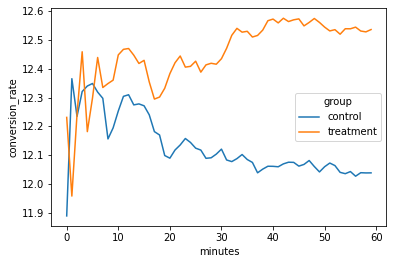

In [193]:
import seaborn as sns
sns.lineplot(data = df3, x = 'minutes', y = 'conversion_rate',hue = 'group')

In [ ]:
#从图里可以看出来，new-page的转化率先上升，之后上升幅度放缓，而old page，只有前10分钟稍好，之后转换率越来越低